In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from collections import Counter

In [3]:
# Importing dataset MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

C:\Users\filip\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X_train = X[:10000]
y_train = y[:10000]
X_val = X[10000:12000]
y_val = y[10000:12000]

X_test = X[12000:14000]
y_test = y[12000:14000]

# EDA

In [5]:
format(X_train[0])

'[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.\n  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.\n   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.\n 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   

In [6]:
# Looking at the shape of X-train and y-train
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (10000, 784)
Shape of y_train: (10000,)


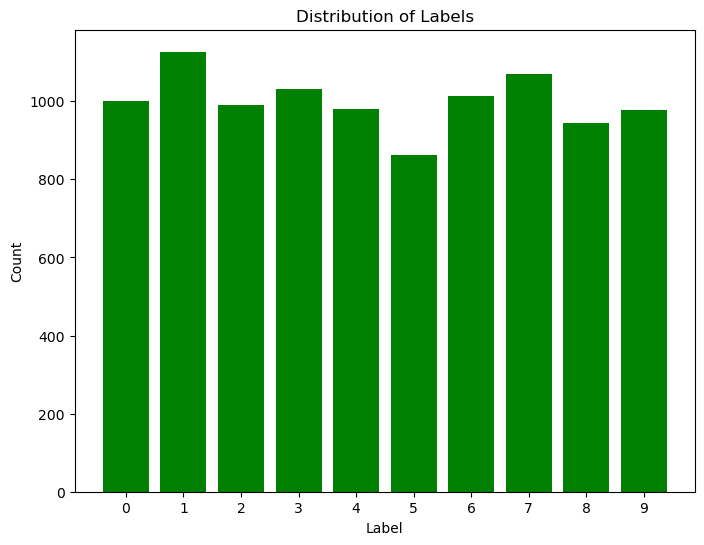

In [7]:
# Plot distribution of labels
label_counts = Counter(y_train)
labels, counts = zip(*label_counts.items())
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color = "green")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(np.arange(0, 10, step=1))
plt.show()

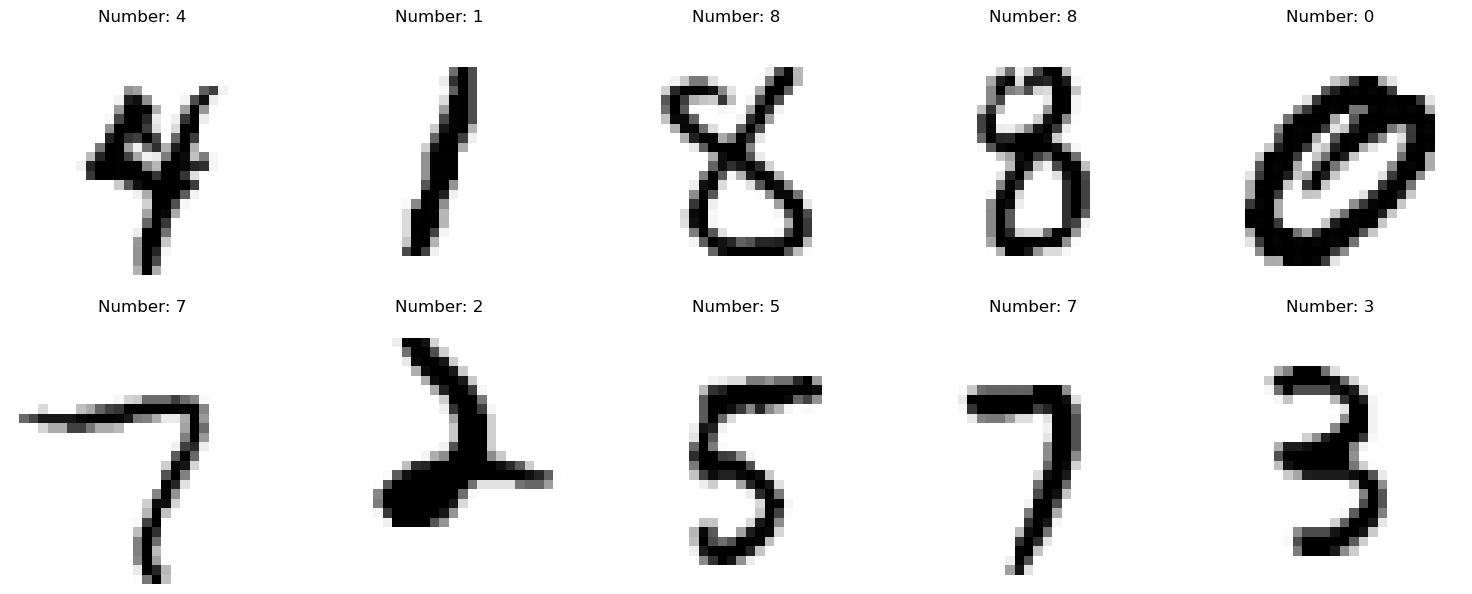

In [8]:
# Looking at 10 random numbers and comparing them to their labels.
random_indices = np.random.randint(0, len(X), size=10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flat):
    random_digit = X[random_indices[i]].reshape(28, 28)
    ax.imshow(random_digit, cmap='binary')
    ax.axis("off")
    ax.set_title(f"Number: {y[random_indices[i]]}") 

plt.tight_layout()
plt.show()

# Data Preparation

In [9]:
#Deskewing data

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [10]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [11]:
examples = (4181, 0), (3,1), (4145, 2), (289,3), (9741,4) , (2901,5)

C:\Users\filip\AppData\Local\Temp\ipykernel_1400\3871789002.py:7: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image,affine,offset=offset)


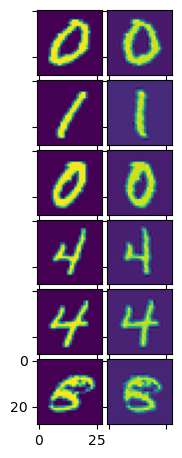

In [12]:
from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(8,15)), 141,
                    nrows_ncols=(6, 2),
                    axes_pad=0.05,
                    label_mode="1",
                    )

for examplenum,num in examples:
    im = grid[2*num].imshow(X_train[examplenum].reshape(28,28))
    im2 = grid[2*num+1].imshow(deskew(X_train[examplenum].reshape(28,28)))

In [13]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_train_deskewed = deskewAll(X_train)
X_val_deskewed = deskewAll(X_val)
X_test_deskewed = deskewAll(X_test)

C:\Users\filip\AppData\Local\Temp\ipykernel_1400\3871789002.py:7: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image,affine,offset=offset)


In [14]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_deskewed)
X_val_scaled = scaler.transform(X_val_deskewed)
X_test_scaled = scaler.transform(X_test_deskewed)

In [15]:
import joblib

# save
joblib.dump(scaler, "scaler") 

['scaler']

# Model Training

In [117]:
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_reg_grid = GridSearchCV(log_reg_model, log_reg_params, cv=3, scoring='accuracy')
log_reg_grid.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg_grid.predict(X_val_scaled)
log_reg_accuracy = accuracy_score(y_val, log_reg_predictions)
print("Logistic Regression Accuracy:", log_reg_accuracy)
print("Best Parameters for Logistic Regression:", log_reg_grid.best_params_)

Logistic Regression Accuracy: 0.944
Best Parameters for Logistic Regression: {'C': 0.01}


In [118]:
rf_model = RandomForestClassifier()
rf_params = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20, 30]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy', n_jobs = -2)
rf_grid.fit(X_train_scaled, y_train)
rf_predictions = rf_grid.predict(X_val_scaled)
rf_accuracy = accuracy_score(y_val, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("Best Parameters for Random Forest:", rf_grid.best_params_)

Random Forest Accuracy: 0.9585
Best Parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}


In [129]:
svm_model = SVC()
svm_params = {'kernel': ['rbf', 'poly'], 'gamma': [0.25, 0.5, 1], 'C': [0.025, 0.05, 0.15]}
svm_grid = GridSearchCV(svm_model, svm_params, cv=3, scoring='accuracy', n_jobs = -2)
svm_grid.fit(X_train_scaled, y_train)
svm_predictions = svm_grid.predict(X_val_scaled)
svm_accuracy = accuracy_score(y_val, svm_predictions)
print("Support Vector Machine Accuracy:", svm_accuracy)
print("Best Parameters for Support Vector Machine:", svm_grid.best_params_)

Support Vector Machine Accuracy: 0.97
Best Parameters for Support Vector Machine: {'C': 0.025, 'gamma': 0.25, 'kernel': 'poly'}


# Testing Chosen Model

In [75]:
test_pred_y = svm_grid.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_pred_y)
print("SVM Test Accuracy:", test_accuracy)

SVM Test Accuracy: 0.967


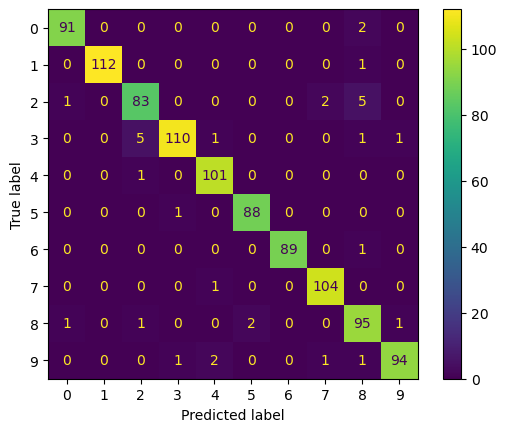

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    
display_confusion_matrix(y_test, test_pred_y)

# Testing chosen model on more data

In [82]:
#Splitting data into train and test splits
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train_big_deskewed = deskewAll(X_train_big)
X_test_big_deskewed = deskewAll(X_test_big)

X_train_big_scaled = scaler.transform(X_train_big_deskewed)
X_test_big_scaled = scaler.transform(X_test_big_deskewed)

C:\Users\filip\AppData\Local\Temp\ipykernel_12536\3871789002.py:7: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image,affine,offset=offset)


In [87]:
svm_big = SVC(C = 0.05, gamma = 0.5, kernel = 'poly')
svm_big.fit(X_train_big_scaled, y_train_big)

SVC(C=0.05, gamma=0.5, kernel='poly')

In [88]:
big_pred_y = svm_grid.predict(X_test_big_scaled)
test_accuracy_big = accuracy_score(y_test_big, big_pred_y)
print("SVM Big Test Accuracy:", test_accuracy)

SVM Big Test Accuracy: 0.967


# Training model on the entire dataset

In [77]:
# Training chosen model on entire dataset
X_deskewed = deskewAll(X)
X_scaled = scaler.transform(X_deskewed)

C:\Users\filip\AppData\Local\Temp\ipykernel_12536\3871789002.py:7: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image,affine,offset=offset)


In [78]:
# Training chosen model on entire dataset
svm_full = SVC(C = 0.05, gamma = 0.5, kernel = 'poly')
svm_full.fit(X_scaled, y)

SVC(C=0.05, gamma=0.5, kernel='poly')

In [80]:
import joblib

# save
joblib.dump(svm_full, "model.full") 

['model.full']